In [2]:
# Importación de librerias.
import pandas as pd
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt

# Carga del dataset. 
analogias_df = pd.read_csv('analogies_answers.csv')
analogias_df.head()

In [3]:
# Embeddings utilizados.
embeddings_WIKI = KeyedVectors.load_word2vec_format('embeddings/wiki.es.vec', limit=None)
embeddings_SUC = KeyedVectors.load_word2vec_format('embeddings/embeddings-l-model.vec', limit=None)
embeddings_SWOW = KeyedVectors.load_word2vec_format('embeddings/swow.embedding.was.26-04-2022.vec', limit=None)
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
embeddings_SBWC = KeyedVectors.load_word2vec_format('embeddings/SBW-vectors-300-min5.txt', limit=None)
embeddings_Glove = KeyedVectors.load_word2vec_format('embeddings/glove-sbwc.i25.vec', limit=None)

In [4]:
# Embedding SWOW pasado a minusculas 

# Vectores y palabras del SWOW.
palabras = list(embeddings_SWOW.key_to_index.keys())
vectores = list(embeddings_SWOW.vectors)

# Convertir todas las palabras a minúsculas.
palabras_minusculas = [palabra.lower() for palabra in palabras]

# Creación de un nuevo modelo SWOW con las palabras y vectores en minúsculas. 
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
lower_embeddings_SWOW.add_vectors(palabras_minusculas, vectores)

In [5]:
# Listado de los embeddings utilizados. 
lista_de_Embeddings = [embeddings_WIKI, embeddings_SUC, lower_embeddings_SWOW, embeddings_SBWC, embeddings_Glove]
#lista_de_Embeddings = [embeddings_WIKI, embeddings_SUC, lower_embeddings_SWOW, embeddings_SBWC, embeddings_Glove

In [6]:
# Calculo de la frecuencia de las combinaciones de 'cue' y 'response' y sus rangos para identificar las analogías más relevantes
analogias_df['count'] = analogias_df.groupby(['cue','response'])['response'].transform('count')
analogias_df['rank'] = analogias_df.groupby('cue')['count'].rank(ascending=False, method='min')

# Calculo del porcentaje de frecuencia de cada combinación en relación con el número total de respuestas para ese 'cue'.
total_respuestas = analogias_df.groupby('cue')['response'].transform('count')
analogias_df['porcentaje'] = (analogias_df['count'] / total_respuestas) * 100

# Indices de filas que tienen rango minimo (rango 1).
idx = analogias_df.groupby(['cue'])['rank'].idxmin()

# Me quedo unicamente con las filas que tienen las combinaciones más relevantes según el rango.
analogias_df = analogias_df.loc[idx]

# Se guarda el DataFrame modificado en un archivo CSV.
analogias_df.to_csv('analogies_answers.csv', index=False)

# Se pasan todas las palabras a minúsculas. 
analogias_df['cueEjemplo'] = analogias_df['cueEjemplo'].apply(lambda x: str(x).lower())
analogias_df['targetEjemplo'] = analogias_df['targetEjemplo'].apply(lambda x: str(x).lower())
analogias_df['cue'] = analogias_df['cue'].apply(lambda x: str(x).lower())

# Se realizan los reemplazos necesarios. 
analogias_df['cueEjemplo'] = analogias_df['cueEjemplo'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogias_df['targetEjemplo'] = analogias_df['targetEjemplo'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogias_df['cue'] = analogias_df['cue'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')


In [1]:
from mis_funciones import metricas_topK, calcular_predicciones

# Funcion calcular predicciones. 
K = 30
todas_predicciones = [calcular_predicciones(e, analogias_df, K) for e in lista_de_Embeddings]

# Funcion calcular metricas topK
topK_metricas_5 = [metricas_topK (prediccion[:1], analogias_df) for prediccion in todas_predicciones]                                                        
topK_metricas_5 = [metricas_topK (prediccion[:5], analogias_df) for prediccion in todas_predicciones]
topK_metricas_10 = [metricas_topK (prediccion[:10], analogias_df) for prediccion in todas_predicciones]
topK_metricas_25 = [metricas_topK (prediccion[:25], analogias_df) for prediccion in todas_predicciones]

print("Todas las metricas 5: ", topK_metricas_5)
print("Todas las metricas 10: ", topK_metricas_10)
print("Todas las metricas 25: ", topK_metricas_25)

#print([len(prediccion) for prediccion in todas_predicciones])

NameError: name 'lista_de_Embeddings' is not defined

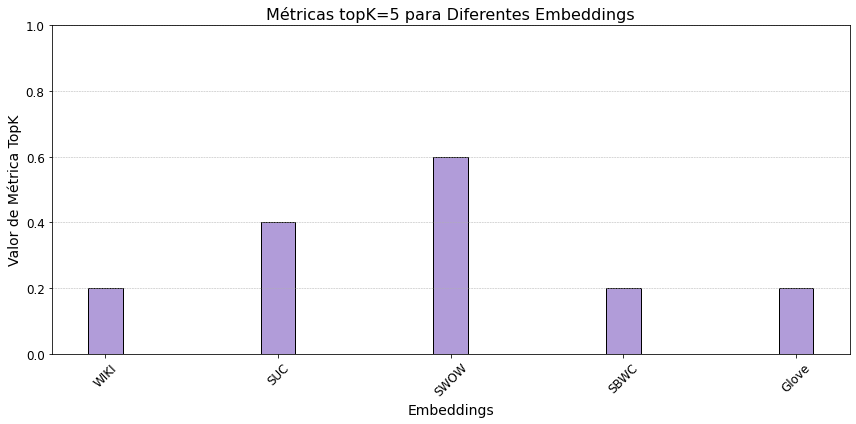

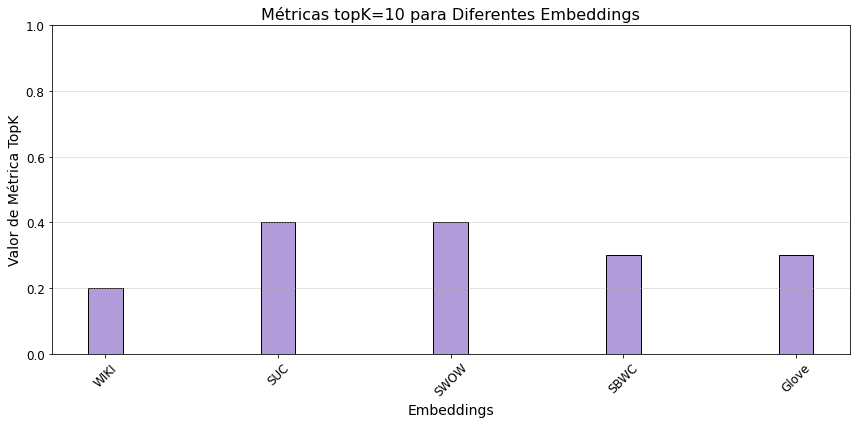

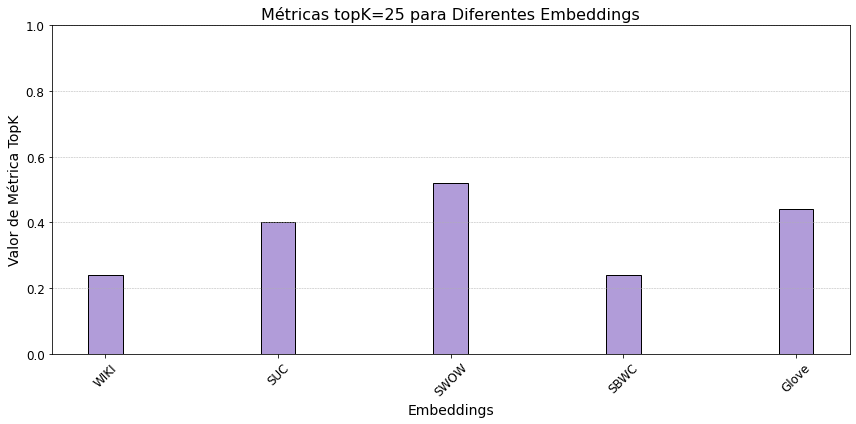

In [34]:
data = topK_metricas_5 + topK_metricas_10 + topK_metricas_25

color_purple_pastel = '#B19CD9'  

lista_de_Nombres = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# Definir el número de embeddings
num_embeddings = len(lista_de_Nombres)

# Definir el ancho de las barras
width = 0.2

data_topK_5 = data[:num_embeddings]
data_topK_10 = data[num_embeddings:2*num_embeddings]
data_topK_25 = data[2*num_embeddings:]

# Crear las tres figuras separadas
for metrica, topK in zip([data_topK_5, data_topK_10, data_topK_25], [5, 10, 25]):
    x = np.arange(num_embeddings)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bar = ax.bar(x, metrica, width, color=color_purple_pastel, edgecolor='black') 
    
    # Etiquetas de ejes y título
    ax.set_xlabel('Embeddings', fontsize=14)
    ax.set_ylabel('Valor de Métrica TopK', fontsize=14)
    ax.set_title(f'Métricas topK={topK} para Diferentes Embeddings', fontsize=16)
    
    ax.set_xticks(x)
    ax.set_xticklabels(lista_de_Nombres, rotation=45, fontsize=12)
    
    # Límites del eje y mostrar valores entre 0 y 1
    ax.set_ylim([0, 1])
    
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    plt.show()
